# Imports

In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pickle
import cv2
import os
import glob
import time
import random
from tqdm import tqdm
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
test_images_path = 'test_images'
vehicles_path = 'vehicles'
non_vehicles_path = 'non-vehicles'
test_images_fn = glob.glob(os.path.join(os.getcwd(),test_images_path, '*.jpg'))
vehicles_fn = glob.glob(os.path.join(os.getcwd(),vehicles_path, '*/*.png'))
non_vehicles_fn = glob.glob(os.path.join(os.getcwd(),non_vehicles_path, '*/*.png'))


In [3]:
def convert_color(img, _to = 'RGB', _from = 'BGR'):
    color_space_transform = eval('cv2.COLOR_'+_from +'2'+_to)
    return cv2.cvtColor(img, color_space_transform)

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    car_img = cv2.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["img_shape"] = car_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["dtype"] = car_img.dtype
    # Return data_dict
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(convert_color(cv2.imread(car_list[0])))
    plt.title('Example Car Image')
    plt.subplot(122)
    plt.imshow(convert_color(cv2.imread(notcar_list[0])))
    plt.title('Example Not-car Image')
    plt.show()
    print('N° of vehicles: {}'.format(data_dict["n_cars"]))
    print('N° of non vehicles: {}'.format(data_dict["n_notcars"]))
    print('Shape: {}'.format(data_dict["img_shape"]))
    print('Data type: {}'.format(data_dict["dtype"]))
    return data_dict

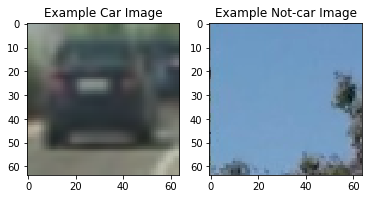

N° of vehicles: 8792
N° of non vehicles: 8968
Shape: (64, 64, 3)
Data type: uint8


In [4]:
data_info = data_look(vehicles_fn, non_vehicles_fn)

In [5]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    output = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=True, feature_vector=feature_vec)
    if vis==True:
        return output[0], output[1]
    else:
        return output[0]

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0, hist_bins =32, spatial_size = (32,32)):
    # Create a list to append feature vectors to
    all_features = []
    # Iterate through the list of images
    for file in tqdm(imgs):
        # Read in each one by one
        image = cv2.imread(file)
        image = image.astype(np.float32)/255
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image, cspace)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                ch_hog_features = get_hog_features(feature_image[:,:,channel], 
                                                   orient, pix_per_cell, cell_per_block, feature_vec=False)
                hog_features.append(ch_hog_features)
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins)
        features = np.hstack((spatial_features, hist_features, hog_features))
        all_features.append(features)
    # Return list of feature vectors
    return all_features

In [6]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 1000
cars = vehicles_fn[0:sample_size]
notcars = non_vehicles_fn[0:sample_size]

params = {'colorspace':'YCrCb',
          'hist_bins':32,
          'orient': 9,
          'pix_per_cell': 8,
          'cell_per_block': 2,
          'hog_channel':'ALL',
          'X_scaler': None, 
          'svc': None,
          'spatial_size': (32,32)}

for key, val in params.items():
        exec(key + '=val')

In [7]:
t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print('{:.2f} Seconds to extract HOG features...'.format(t2-t))


# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 


100%|██████████████████████████████████████| 1000/1000 [05:56<00:00,  2.95it/s]


573.40 Seconds to extract HOG features...


In [8]:

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC



Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
1.79 Seconds to train SVC...


Test Accuracy of SVC = 0.9975
My SVC predicts: [ 1.  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.  0.]
For these 16 labels:  [ 1.  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.  0.]
0.04853 Seconds to predict 16 labels with SVC


100%|██████████████████████████████████████████| 20/20 [00:07<00:00,  2.62it/s]


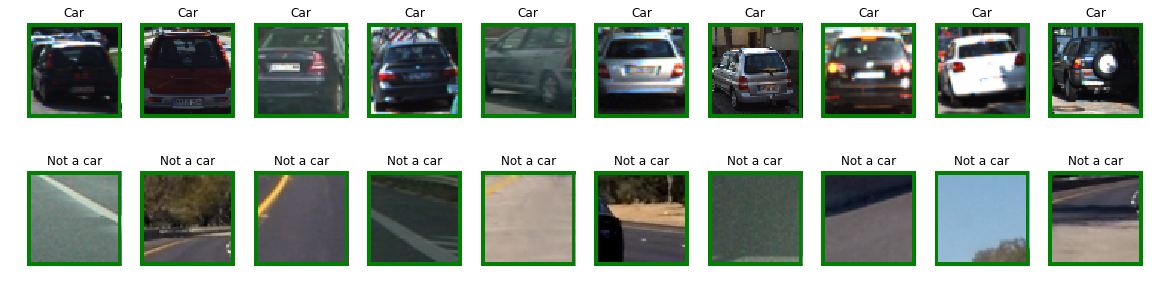

In [9]:
accuracy = svc.score(X_test, y_test)
print('Test Accuracy of SVC = {:.4f}'.format(accuracy))
# Check the prediction time for a single sample
t=time.time()
n_predict = 16
predicts = svc.predict(X_test[0:n_predict])
print('My SVC predicts: '+ str(predicts))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')


labels = {0:'Not a car', 1:'Car'}
plot_test = np.append(np.random.choice(vehicles_fn, 10),np.random.choice(non_vehicles_fn,10))
plot_features = extract_features(plot_test, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
plot_x = X_scaler.transform(plot_features)
fig, axes = plt.subplots(2, 10,figsize = (20,5))
for i, ax in enumerate(axes.flat):
    ax.imshow(convert_color(cv2.imread(plot_test[i])))
    pred = svc.predict(plot_x[i].reshape(1, -1))[0]
    ax.set_title(labels[pred])
    color = 'green' if (pred == 1-i//10) else 'red'
    ax.add_patch(patches.Rectangle((0, 0), 63,63, fill=False,edgecolor=color,linewidth=6))
    ax.axis('off')
plt.show()



In [10]:
try:
    params = pickle.load(open('parameters.p', 'rb'))
    print('parameters loaded successfully')
except:
    for key in params.keys():
        params[key] =  eval(key)
    pickle.dump(params, open('parameters.p', 'wb'))
    print('parameters saved successfully')

parameters saved successfully


3.0


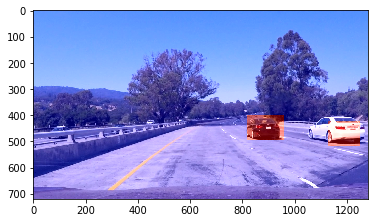

In [11]:
for key in params.keys():
    params[key] =  eval(key)

img = convert_color(cv2.imread(test_images_fn[0]),'RGB')

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch,'YCrCb','RGB')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
   
    heatmap = np.zeros(img.shape[:2])
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            features = np.hstack((spatial_features, hist_features, hog_features))
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(features).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart,xbox_left:xbox_left+win_draw] += 1
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
    heatmap[np.where(heatmap == 0)] = -1
    return draw_img, heatmap
    
ystart = 400
ystop = 656
scale = 1.5
cmap = plt.get_cmap('jet')
heatmap = np.zeros(img.shape[:2])
out_img, current_frame_heatmap = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
heatmap = np.maximum(np.zeros(img.shape[:2]), heatmap + current_frame_heatmap)
print(np.max(heatmap))
plt.figure()
rgba_heatmap = cmap(heatmap*255)
rgb_heatmap = np.delete(rgba_heatmap, 3, 2)
result = cv2.addWeighted(img, 1, (255*rgb_heatmap).astype('uint8'), 0.8, 0)
plt.imshow(result)
plt.show()

In [12]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [13]:
cmap([0,1,255,500,128])

array([[ 0.        ,  0.        ,  0.5       ,  1.        ],
       [ 0.        ,  0.        ,  0.51782531,  1.        ],
       [ 0.5       ,  0.        ,  0.        ,  1.        ],
       [ 0.5       ,  0.        ,  0.        ,  1.        ],
       [ 0.49019608,  1.        ,  0.47754586,  1.        ]])

In [19]:
def update_heatmap(old_heatmap, current_heatmap):
    return np.maximum(np.zeros_like(old_heatmap), old_heatmap + current_heatmap)

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold]  = 0
    return heatmap

In [22]:
sto= {'heatmap':np.zeros(img.shape[:2])}
def process_video(frame):
    out_img, current_frame_heatmap = find_cars(frame, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    sto['heatmap'] = update_heatmap(sto['heatmap'], current_frame_heatmap)
    print(np.max(sto['heatmap'])*.5)
    sto['heatmap'] = apply_threshold(sto['heatmap'],np.max(sto['heatmap'])*.2)
    labels = label(sto['heatmap'])
    draw_img = draw_labeled_bboxes(np.copy(frame), labels)
    rgba_heatmap = cmap(255*sto['heatmap'])
    rgb_heatmap = np.delete(rgba_heatmap, 3, 2)
    result = cv2.addWeighted(draw_img, 1, 255*(rgb_heatmap).astype('uint8'), 0.8, 0)
    return result

In [ ]:

write_output = 'video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
write_clip = clip1.fl_image(process_video)
%time write_clip.write_videofile(write_output, audio=False)

2.5
[MoviePy] >>>> Building video video_output.mp4
[MoviePy] Writing video video_output.mp4


  0%|                                                   | 0/39 [00:00<?, ?it/s]

5.0


  3%|█                                          | 1/39 [00:48<30:55, 48.82s/it]

8.0


  5%|██▏                                        | 2/39 [01:43<31:13, 50.62s/it]

11.0


  8%|███▎                                       | 3/39 [02:36<30:50, 51.40s/it]

13.5


 10%|████▍                                      | 4/39 [03:26<29:37, 50.77s/it]

16.0


 13%|█████▌                                     | 5/39 [04:20<29:26, 51.96s/it]

18.5


 15%|██████▌                                    | 6/39 [05:09<27:58, 50.85s/it]

21.0


 18%|███████▋                                   | 7/39 [06:00<27:10, 50.95s/it]

23.5


 21%|████████▊                                  | 8/39 [06:50<26:16, 50.86s/it]

26.0


 23%|█████████▉                                 | 9/39 [07:38<24:57, 49.93s/it]

28.5


 26%|██████████▊                               | 10/39 [08:25<23:39, 48.94s/it]

31.0


 28%|███████████▊                              | 11/39 [09:10<22:20, 47.87s/it]

33.5


 31%|████████████▉                             | 12/39 [09:59<21:42, 48.23s/it]

36.5


 33%|██████████████                            | 13/39 [10:51<21:19, 49.21s/it]

39.0


 36%|███████████████                           | 14/39 [11:41<20:34, 49.39s/it]

42.0


 38%|████████████████▏                         | 15/39 [12:33<20:03, 50.15s/it]

44.5


 41%|█████████████████▏                        | 16/39 [13:20<18:57, 49.46s/it]

47.0


 44%|██████████████████▎                       | 17/39 [14:09<18:01, 49.15s/it]

49.5


 46%|███████████████████▍                      | 18/39 [14:59<17:20, 49.56s/it]

52.0


 49%|████████████████████▍                     | 19/39 [15:51<16:44, 50.25s/it]

54.0


 51%|█████████████████████▌                    | 20/39 [16:35<15:20, 48.44s/it]

56.0


 54%|██████████████████████▌                   | 21/39 [17:20<14:09, 47.22s/it]

58.0


 56%|███████████████████████▋                  | 22/39 [18:03<13:03, 46.11s/it]

60.5


 59%|████████████████████████▊                 | 23/39 [18:46<12:02, 45.14s/it]

63.0


 62%|█████████████████████████▊                | 24/39 [19:30<11:11, 44.77s/it]

65.5


 64%|██████████████████████████▉               | 25/39 [20:14<10:24, 44.63s/it]

68.0


 67%|████████████████████████████              | 26/39 [20:59<09:41, 44.72s/it]

70.5


 69%|█████████████████████████████             | 27/39 [21:43<08:53, 44.47s/it]

73.5


 72%|██████████████████████████████▏           | 28/39 [22:27<08:05, 44.18s/it]

76.0


 74%|███████████████████████████████▏          | 29/39 [23:12<07:24, 44.48s/it]

78.5


 77%|████████████████████████████████▎         | 30/39 [23:59<06:48, 45.39s/it]

81.0


 79%|█████████████████████████████████▍        | 31/39 [24:43<05:58, 44.76s/it]

83.0


 82%|██████████████████████████████████▍       | 32/39 [25:26<05:10, 44.40s/it]

85.0


 85%|███████████████████████████████████▌      | 33/39 [26:10<04:25, 44.27s/it]

86.5


 87%|████████████████████████████████████▌     | 34/39 [26:54<03:39, 44.00s/it]

88.0


 90%|█████████████████████████████████████▋    | 35/39 [27:38<02:56, 44.07s/it]

90.0


 92%|██████████████████████████████████████▊   | 36/39 [28:24<02:14, 44.81s/it]

91.5


 95%|███████████████████████████████████████▊  | 37/39 [29:11<01:30, 45.42s/it]

In [ ]:
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('video_output4.mp4'))

In [ ]:
fig = plt.figure(figsize=(20,20))
img = convert_color(cv2.imread(vehicles_fn[0]))
plt.imshow(img)
plt.show()
ystart, ystop  = []